In [23]:
# import the necessary packages
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import imutils
import cv2
import os

In [25]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

In [26]:
class Config:
    # base path to YOLO directory
    MODEL_PATH = "yolo-coco"

    # initialize minimum probability to filter weak detections along with
    # the threshold when applying non-maxima suppression
    MIN_CONF = 0.3
    NMS_THRESH = 0.3

    # boolean indicating if NVIDIA CUDA GPU should be used
    USE_GPU = False

    # define the minimum safe distance (in pixels) that two people can be
    # from each other
    MIN_DISTANCE = 100

# instantiate our Config object
config = Config()

In [27]:
def detect_people(frame, net, ln, personIdx=0):
	# grab the dimensions of the frame and  initialize the list of
	# results
	(H, W) = frame.shape[:2]
	results = []

    # construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	layerOutputs = net.forward(ln)

	# initialize our lists of detected bounding boxes, centroids, and
	# confidences, respectively
	boxes = []
	centroids = []
	confidences = []

    # loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter detections by (1) ensuring that the object
			# detected was a person and (2) that the minimum
			# confidence is met
			if classID == personIdx and confidence > config.MIN_CONF:
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top
				# and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates,
				# centroids, and confidences
				boxes.append([x, y, int(width), int(height)])
				centroids.append((centerX, centerY))
				confidences.append(float(confidence))

    # apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, config.MIN_CONF, config.NMS_THRESH)

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			# update our results list to consist of the person
			# prediction probability, bounding box coordinates,
			# and the centroid
			r = (confidences[i], (x, y, x + w, y + h), centroids[i])
			results.append(r)

	# return the list of results
	return results

In [28]:
args = {
    "input": "videos/car_chase_01.mp4",
    "output": "output.avi",
    "display": 0
}

In [29]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([config.MODEL_PATH, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([config.MODEL_PATH, "yolov3.weights"])
configPath = os.path.sep.join([config.MODEL_PATH, "yolov3.cfg"])

In [32]:
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# check if we are going to use GPU
if config.USE_GPU:
	# set CUDA as the preferable backend and target
	print("[INFO] setting preferable backend and target to CUDA...")
	net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
	net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

[INFO] loading YOLO from disk...


In [33]:
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream and pointer to output video file
print("[INFO] accessing video stream...")
vs = cv2.VideoCapture(args["input"] if args["input"] else 0)
writer = None

[INFO] accessing video stream...


In [34]:
# loop over the frames from the video stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# resize the frame and then detect people (and only people) in it
	frame = imutils.resize(frame, width=700)
	results = detect_people(frame, net, ln,
		personIdx=LABELS.index("car"))

	# initialize the set of indexes that violate the minimum social
	# distance
	violate = set()

    # ensure there are *at least* two people detections (required in
	# order to compute our pairwise distance maps)
	if len(results) >= 2:
		# extract all centroids from the results and compute the
		# Euclidean distances between all pairs of the centroids
		centroids = np.array([r[2] for r in results])
		D = dist.cdist(centroids, centroids, metric="euclidean")

		# loop over the upper triangular of the distance matrix
		for i in range(0, D.shape[0]):
			for j in range(i + 1, D.shape[1]):
				# check to see if the distance between any two
				# centroid pairs is less than the configured number
				# of pixels
				if D[i, j] < config.MIN_DISTANCE:
					# update our violation set with the indexes of
					# the centroid pairs
					violate.add(i)
					violate.add(j)

    # loop over the results
	for (i, (prob, bbox, centroid)) in enumerate(results):
		# extract the bounding box and centroid coordinates, then
		# initialize the color of the annotation
		(startX, startY, endX, endY) = bbox
		(cX, cY) = centroid
		color = (0, 255, 0)

		# if the index pair exists within the violation set, then
		# update the color
		if i in violate:
			color = (0, 0, 255)

		# draw (1) a bounding box around the person and (2) the
		# centroid coordinates of the person,
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
		cv2.circle(frame, (cX, cY), 5, color, 1)

	# draw the total number of social distancing violations on the
	# output frame
	text = "Distancing Violations: {}".format(len(violate))
	cv2.putText(frame, text, (10, frame.shape[0] - 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)

    # check to see if the output frame should be displayed to our
	# screen
	if args["display"] > 0:
		# show the output frame
		cv2.imshow("Frame", frame)
		key = cv2.waitKey(1) & 0xFF

		# if the `q` key was pressed, break from the loop
		if key == ord("q"):
			break

	# if an output video file path has been supplied and the video
	# writer has not been initialized, do so now
	if args["output"] != "" and writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 25,
			(frame.shape[1], frame.shape[0]), True)

	# if the video writer is not None, write the frame to the output
	# video file
	if writer is not None:
		writer.write(frame)

# do a bit of cleanup
vs.release()

# check to see if the video writer point needs to be released
if writer is not None:
	writer.release()

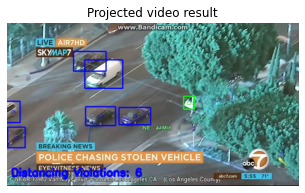

In [35]:
# displaying projected video
from IPython.display import clear_output
vid = cv2.VideoCapture("output.avi")

while(True):
    ret, frame = vid.read()
    if not ret:
        vid.release()
        break
    fig = plt.figure(figsize=(12,3))
    
    plt.title("Projected video result")
    plt.axis('off')
    plt.imshow(frame)
    plt.show()
    # clear current frame for next frame
    clear_output(wait=True)

vid.release()